### CRASH fMRI Matfiles
Each fMRI scan has been converted into a MATLAB matfile for each parcellation. These matfiles contain the data needed to do functional connectivity analysis while accounting for many confounds. The parcellation used is included in the file name. Here we load a resting state scan that has been masked by the Schaefer200+ atlas.

The variables contained in the file (and their shapes) are:

In [16]:
%pylab inline
import numpy as np
from scipy.io.matlab import loadmat
import matplotlib.pyplot as plt

fdir = '/host/data/MRI_EEG/fmri/matfiles/sub-0001a/ses-1/'
# mat = loadmat(fdir+'sub-0001a_ses-1_rest_fMRI_schaefer200plus.mat')
mat = loadmat(fdir+'sub-0001a_ses-1_task-VWM-1_fMRI_schaefer200plus.mat')

print("Matfile contains:")
for key in mat:
    if key.startswith("__"): continue # Skip the MATLAB metadata
    print("    ", key, ":", mat[key].shape)

Populating the interactive namespace from numpy and matplotlib
Matfile contains:
     bold : (302, 214)
     corrected_bold : (302, 214)
     motion : (302, 214)
     nuisance : (302, 214)
     drift : (302, 214)
     cardiac : (302, 214)
     resp : (302, 214)
     rc_interaction : (302, 214)
     csf_signal : (1, 302)
     wm_signal : (1, 302)
     global_signal : (302, 1)


/home/sikun/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['mat']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


There are two kinds of variables here. Whole-brain variables are calculated using entire volumes, while region-specific variables are created for each region in the parcellation. Whole-brain variables have a single data point per TR, while region-specific variables have one row per TR and one column per region in the parcellation.

All of these variables have been standardized to have zero mean and unit variance.

### Whole-brain variables
The simplest variable is bold, which contains the mean BOLD signal in each region at each TR.

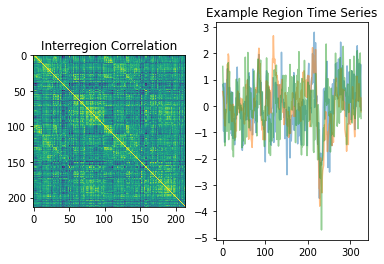

In [15]:
bold = mat['bold'].squeeze()
fig,ax = plt.subplots(ncols=2)

cormat = np.corrcoef(bold.T)
ax[0].imshow(cormat, interpolation="nearest")
ax[0].set_title("Interregion Correlation")

ax[1].plot(bold[:,10],alpha=0.5)
ax[1].plot(bold[:,100],alpha=0.5)
ax[1].plot(bold[:,200],alpha=0.5)
ax[1].set_title("Example Region Time Series");

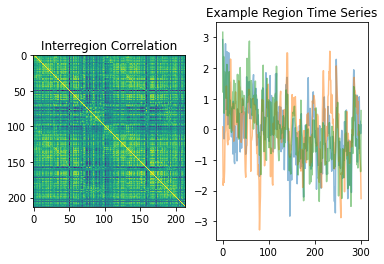

In [17]:
bold = mat['bold'].squeeze()
fig,ax = plt.subplots(ncols=2)

cormat = np.corrcoef(bold.T)
ax[0].imshow(cormat, interpolation="nearest")
ax[0].set_title("Interregion Correlation")

ax[1].plot(bold[:,10],alpha=0.5)
ax[1].plot(bold[:,100],alpha=0.5)
ax[1].plot(bold[:,200],alpha=0.5)
ax[1].set_title("Example Region Time Series");

### Nuisance variables
The variables motion, rc_interaction, cardiac, drift and resp are region-specific nuisance variables. nuisance contains the fit of the entire RETROICOR nusiance model and the drift.

Note: motion is not included in the RETROICOR nuisance model because it is likely correlated with drift.

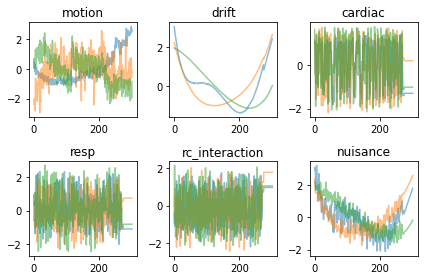

In [18]:
fig,ax = plt.subplots(ncols=3, nrows=2)
fax = ax.flatten()

motion = mat['motion']
resp = mat['resp']
cardiac = mat['cardiac']
rc_interaction = mat['rc_interaction']
drift = mat['drift']

for axnum, variable in enumerate(["motion", "drift", "cardiac",
                                  "resp", "rc_interaction","nuisance"]):
    data = mat[variable]
    fax[axnum].plot(data[:,10],alpha=0.5)
    fax[axnum].plot(data[:,100],alpha=0.5)
    fax[axnum].plot(data[:,200],alpha=0.5)
    fax[axnum].set_title(variable);
tight_layout()

### Corrected and raw BOLD
All of these variables represent averages across all the voxels contained in a region. It is important to remember that RETROICOR creates a unique model at each slice. Each of the cardiac, drift, resp and rc_interaction variables were created by first fitting the RETROICOR model in each voxel, then averaging the fits of the noise models (without the signal included). Specifically, the whole model for voxel  i  is:

yi(t)=βX(t)+s(t)
 
where  s(t)  is the "true" BOLD signal at time  t . The RETROICOR model (including Legendre polynomials for drift) is  X(t) . The nuisance variable contains the average of  β̂ X(t)  over all voxels in each region. The other variables are the model broken into components

yi(t)=βcX(t)+βrX(t)+βrcX(t)+βdX(t)+s(t)
 
where  βr  is the coefficients from fitting the whole model  X(t)  with all but the respiration coefficients zeroed out. Similarly,  βc  contains non-zero estimates from cardiac regressors,  βcr  the interaction terms and  βd  the drift terms. In other words, after fitting the following relationship holds within a single voxel:

β̂ =βc^+βr^+βrc^+βd^
 
In the matfiles, the resp variable is  βr^X(t)  averaged over all voxels in a region. Similarly cardiac is the average of  βc^X(t) , rc_interaction is the average of  βrc^X(t) , drift is average of  βd^X(t)  and corrected_bold is the average of s(t) at each TR  t .

Because these are averages across all voxels in a region, is not necessarily true that nuisance == resp + cardiac + rc_interaction + drift. Another important reason this is not true is that these variables have been changed to have zero-mean and unit variance. The average of the fitted values is not the same as the fit of the averaged values.

The BOLD that has been corrected with RETROICOR and detrending is available in corrected_bold. The data in corrected_bold has first been corrected, then averaged across the voxels.

Another potentially important fact is that the time series within each voxel was converted to percent signal change before the model was fit.

Here are some examples of randomly selected regions and their raw BOLD and corrected BOLD.

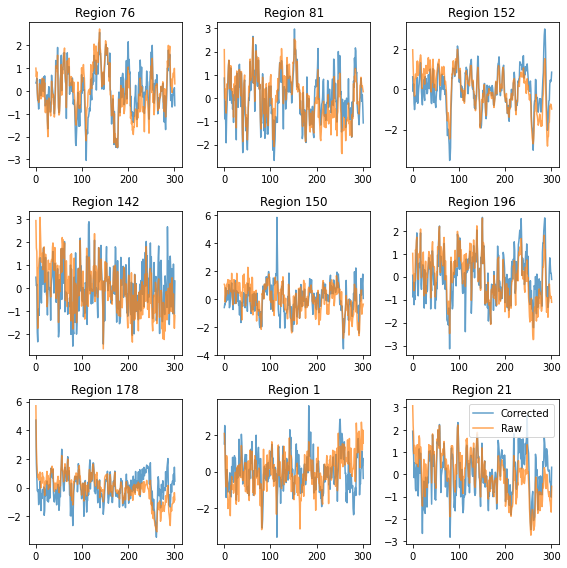

In [19]:
random_regions = np.random.choice(bold.shape[1], size=9, replace=False)

fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(8,8))
fax = ax.flatten()

for n_region, region in enumerate(random_regions):
    fax[n_region].plot(mat["corrected_bold"][:,region],alpha=0.7,label="Corrected")
    fax[n_region].plot(mat["bold"][:,region],alpha=0.7,label="Raw")
    fax[n_region].set_title("Region %d" % region)
fax[n_region].legend()
tight_layout();


### Whole-brain measurements
It is useful to compare BOLD signal to global signal (the average value across all brain voxels), the signal in CSF and the signal in white matter. These variables are available in each matfile, but as a 1D array.

Here are these variables for this particular scan and their correlation values with one another.

CSF and WM correlation 0.3481952260904673
CSF and Global Signal correlation 0.12768851839220433
WM and Global Signal correlation 0.5196045053269746


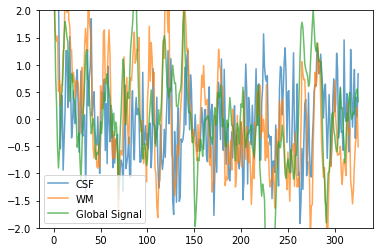

In [6]:
csf_signal = mat["csf_signal"].squeeze()
wm_signal = mat["wm_signal"].squeeze()
global_signal = mat["global_signal"].squeeze()

plot(csf_signal, label="CSF", alpha=0.7)
plot(wm_signal, label = "WM", alpha=0.7)
plot(global_signal, label = "Global Signal", alpha=0.7)
ylim(-2,2)
legend();

print("CSF and WM correlation", np.corrcoef(csf_signal,wm_signal)[0,1])
print("CSF and Global Signal correlation", np.corrcoef(csf_signal,global_signal)[0,1])
print("WM and Global Signal correlation", np.corrcoef(wm_signal, global_signal)[0,1])

This data lets us examine how changes in motion and physiology are manifested in not only BOLD, but also in the global signal, white matter and csf in a region-to-region basis. Here are some quick correlations between regional nuisance values and global signal:

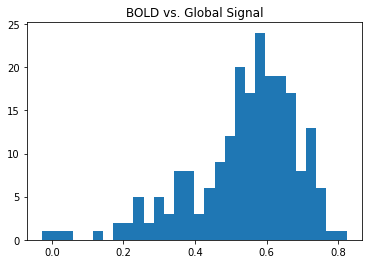

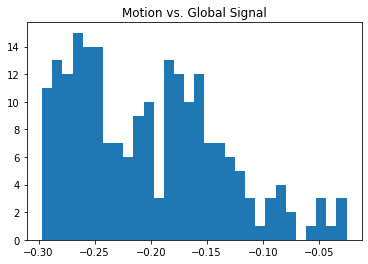

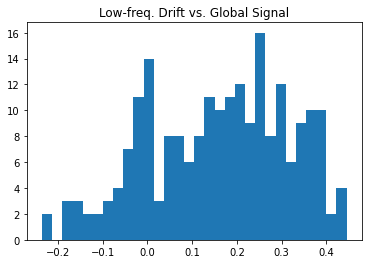

In [7]:
def check_regional_correlations(regional_values, global_values, plot_title=""):
    """
    compares a matrix of regional values to an array of global values
    """
    figure()
    correlations = np.array(
        [np.corrcoef(global_values, regional)[0,1] for regional in regional_values.T])
    hist(correlations,bins=30)
    title(plot_title)
    
check_regional_correlations(mat["bold"], global_signal, "BOLD vs. Global Signal")
check_regional_correlations(mat["motion"], global_signal, "Motion vs. Global Signal")
check_regional_correlations(mat["drift"], global_signal,"Low-freq. Drift vs. Global Signal")

Unsurprisingly, BOLD is positively correlated with global signal. Motion is negatively correlated with global signal, which is also expected. Low-frequency drifts are also positively correlated with global signal, but not as highly as the whole BOLD signal itself.

### Additional whole-brain measurements¶
Nick and Steve have calculated DVARS, FD and whole-brain motion parameters for each of these scans. These could also be used as whole-brain nuisance variables. It would be interesting to see how they correlate with region-specific motion.

### data locations

on x: /host/data/MRI_EEG/fmri/matfiles/

on crash server: /crash-work/finished/matfiles

last modified scripts (on crash server): /crash-work/finished/matfiles/scripts_sk